***Applying on MNIST Dataset*****

In [1]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

# Set global seed for reproducibility
global_seed = 123
np.random.seed(global_seed)
torch.manual_seed(global_seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Check PyTorch version and if GPU is available
print("\nPyTorch Version: " + torch.__version__)


PyTorch Version: 2.4.0


In [2]:
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Subset

# Define the transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [0, 1] range and then to [-1, 1]
])

# Load the Fashion-MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Get the training data and labels
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

100%|██████████| 26421880/26421880 [00:08<00:00, 3170793.09it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 104465.26it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1638526.81it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4085577.48it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Epoch 1/50: disc-loss = 1.1205, gen-loss = 1.0765
Epoch 2/50: disc-loss = 0.8295, gen-loss = 1.9755
Epoch 3/50: disc-loss = 0.7026, gen-loss = 2.4249
Epoch 4/50: disc-loss = 0.6683, gen-loss = 2.4693
Epoch 5/50: disc-loss = 0.6444, gen-loss = 2.6200
Epoch 6/50: disc-loss = 0.7147, gen-loss = 2.3415
Epoch 7/50: disc-loss = 0.7352, gen-loss = 2.3148
Epoch 8/50: disc-loss = 0.7303, gen-loss = 2.2905
Epoch 9/50: disc-loss = 0.7365, gen-loss = 2.3315
Epoch 10/50: disc-loss = 0.7239, gen-loss = 2.3530
Epoch 11/50: disc-loss = 0.7870, gen-loss = 2.1106
Epoch 12/50: disc-loss = 0.8244, gen-loss = 2.0030
Epoch 13/50: disc-loss = 0.8586, gen-loss = 1.8573
Epoch 14/50: disc-loss = 0.8903, gen-loss = 1.7811
Epoch 15/50: disc-loss = 0.9363, gen-loss = 1.6490
Epoch 16/50: disc-loss = 0.9668, gen-loss = 1.5675
Epoch 17/50: disc-loss = 1.0391, gen-loss = 1.4221
Epoch 18/50: disc-loss = 1.0590, gen-loss = 1.3464
Epoch 19/50: disc-loss = 1.0697, gen-loss = 1.3282
Epoch 20/50: disc-loss = 1.0805, gen-los

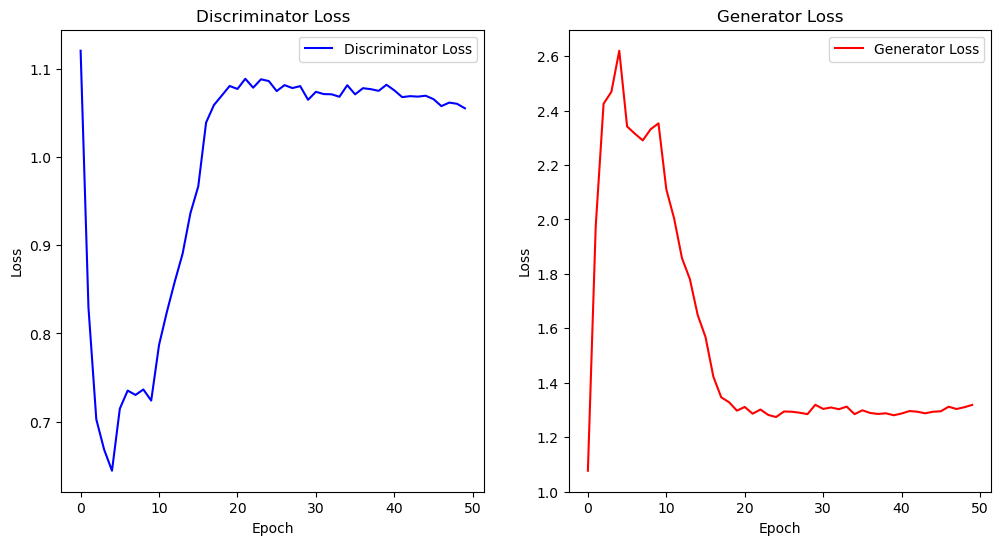

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters
batch_size = 64
lr = 0.0001  # Reduced learning rate
epochs = 50
latent_dim = 64  # Reduced latent dimension

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(mnist_data, batch_size=batch_size, shuffle=True)

# Define the Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 1, 28, 28)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Initialize models and optimizers
generator = Generator()
discriminator = Discriminator()
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Track losses
history = {'disc-loss': [], 'gen-loss': []}

# Training
for epoch in range(epochs):
    dis_losses = []
    gen_losses = []
    for i, (imgs, _) in enumerate(data_loader):
        real_imgs = imgs
        batch_size = real_imgs.size(0)

        # Prepare labels with label smoothing
        real_labels = torch.full((batch_size, 1), 0.9)  # Smooth real labels to 0.9 instead of 1
        fake_labels = torch.zeros(batch_size, 1)

        # Train Discriminator
        optimizer_D.zero_grad()
        z = torch.randn(batch_size, latent_dim)
        fake_imgs = generator(z)
        real_loss = adversarial_loss(discriminator(real_imgs), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim)
        fake_imgs = generator(z)
        gen_loss = adversarial_loss(discriminator(fake_imgs), real_labels)  # Label as real to "fool" discriminator
        gen_loss.backward()
        optimizer_G.step()

        # Save losses
        dis_losses.append(d_loss.item())
        gen_losses.append(gen_loss.item())

    print(f"Epoch {epoch + 1}/{epochs}: disc-loss = {np.mean(dis_losses):.4f}, gen-loss = {np.mean(gen_losses):.4f}")
    history['disc-loss'].append(np.mean(dis_losses))
    history['gen-loss'].append(np.mean(gen_losses))

# Plot losses
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['disc-loss'], label="Discriminator Loss", color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['gen-loss'], label="Generator Loss", color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()
plt.show()
